## Part 1: Libraries 

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

## Part 2: Load Data

In [68]:
# Part 2: Load Data
def load_data(file_path):
    """Load sparse LibSVM dataset into a dense NumPy array."""
    data = []
    labels = []
    num_features = 123
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            labels.append(int(parts[0]))
            features = np.zeros(num_features + 1)
            features[-1] = 1  # Bias term
            for item in parts[1:]:
                index, value = map(float, item.split(':'))
                features[int(index) - 1] = value
            data.append(features)
    return np.array(data), np.array(labels)

# Load training and test data
X_train, y_train = load_data("a9a.train.txt")
X_test, y_test = load_data("a9a.test.txt")

##  Part 3: Compute Gradient and SGD Update

In [76]:

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logreg_loss(X, y, w):
    """Compute logistic regression loss."""
    m = X.shape[0]
    z = X @ w
    return np.mean(np.log(1 + np.exp(-y * z)))

def logreg_error(X, y, w):
    """Compute classification error."""
    predictions = np.sign(X @ w)
    return np.mean(predictions != y)


def logreg_sgd(X, y, w_init, alpha, sigma, T):
    """Perform SGD for logistic regression."""
    m, n = X.shape
    w = w_init.copy()
    losses = []
    errors = []
    val_errors = []
    
    # Append initial loss/error before training starts
    losses.append(logreg_loss(X, y, w))
    errors.append(logreg_error(X, y, w))
    val_errors.append(logreg_error(X_test, y_test, w))
    
    for t in range(T):
        i = np.random.randint(m)  # Random sample index
        x_i, y_i = X[i], y[i]
        gradient = -y_i * x_i / (1 + np.exp(y_i * (x_i @ w))) + 2 * sigma * w
        w -= alpha * gradient
        
        if (t + 1) % 32561 == 0:
            losses.append(logreg_loss(X, y, w))
            errors.append(logreg_error(X, y, w))
            val_errors.append(logreg_error(X_test, y_test, w))
    
    return w, losses, errors, val_errors

## Part 4: Train and Evaluate SGD

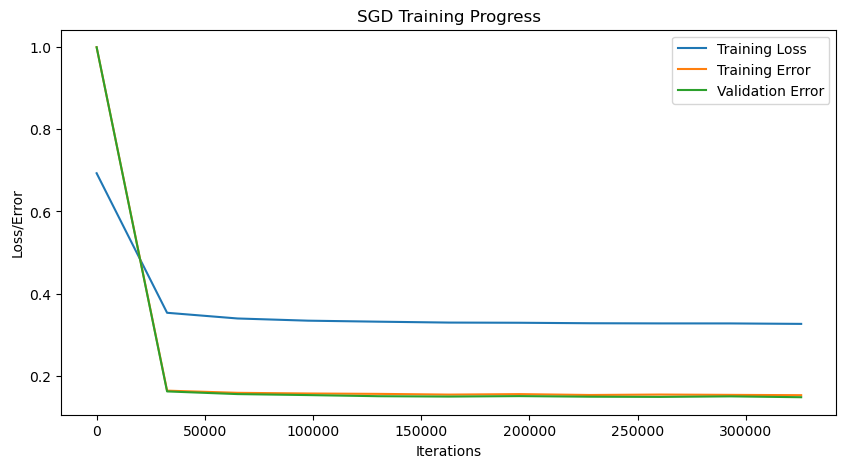

Training Loss: 0.32629990162413397
Training Error: 0.15269801296028992
Test Error: 0.1477181991278177


In [78]:
# Part 4: Train and Evaluate SGD
w_init = np.zeros(X_train.shape[1])
alpha = 0.001
sigma = 0.0001
T = 32561 * 10

w_trained, train_losses, train_errors, val_errors = logreg_sgd(X_train, y_train, w_init, alpha, sigma, T)

# Plot results
iterations = list(range(0, T+1, 32561))
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_losses, label='Training Loss')
plt.plot(iterations, train_errors, label='Training Error')
plt.plot(iterations, val_errors, label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('Loss/Error')
plt.legend()
plt.title('SGD Training Progress')
plt.show()

print(f"Training Loss: {train_losses[-1]}")
print(f"Training Error: {train_errors[-1]}")
print(f"Test Error: {val_errors[-1]}")

## Part 5: Hyperparameter Exploration

Testing alpha=0.01, sigma=0.0001
Testing alpha=0.001, sigma=0.001
Testing alpha=0.0001, sigma=0.0001
Best Hyperparameters: alpha=0.001, sigma=0.001
Best Validation Error: 0.15109637000184264


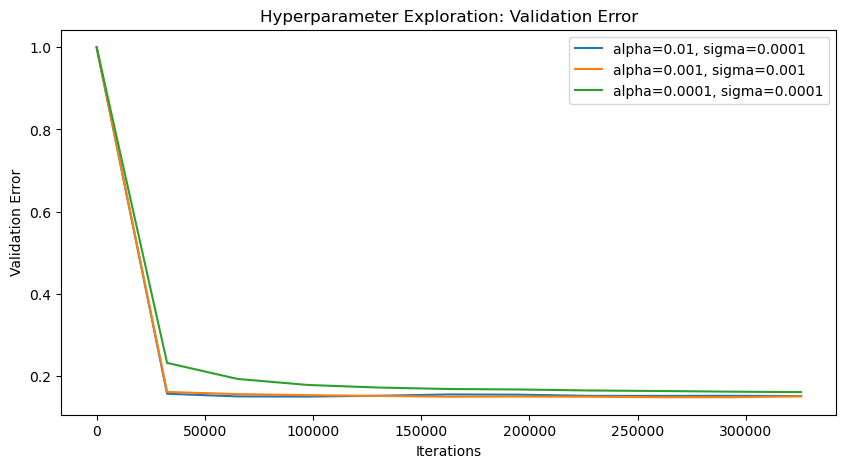

In [82]:

hyperparams = [(0.01, 0.0001), (0.001, 0.001), (0.0001, 0.0001)]  # Different (alpha, sigma) values
results = {}
min_val_error = float('inf')
best_hyperparams = None

for alpha, sigma in hyperparams:
    print(f"Testing alpha={alpha}, sigma={sigma}")
    w_trained, train_losses, train_errors, val_errors = logreg_sgd(X_train, y_train, w_init, alpha, sigma, T)
    results[(alpha, sigma)] = (train_losses, train_errors, val_errors)
    
    if val_errors[-1] < min_val_error:
        min_val_error = val_errors[-1]
        best_hyperparams = (alpha, sigma)

# Print best hyperparameter settings
print(f"Best Hyperparameters: alpha={best_hyperparams[0]}, sigma={best_hyperparams[1]}")
print(f"Best Validation Error: {min_val_error}")

# Plot comparison
plt.figure(figsize=(10, 5))
for (alpha, sigma), (train_losses, train_errors, val_errors) in results.items():
    plt.plot(iterations, val_errors, label=f'alpha={alpha}, sigma={sigma}')
plt.xlabel('Iterations')
plt.ylabel('Validation Error')
plt.legend()
plt.title('Hyperparameter Exploration: Validation Error')
plt.show()

## Part 6: Logistic regression in PyTorch.

In [123]:
# Feature Scaling
scaler = StandardScaler()
X_train_scale= scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

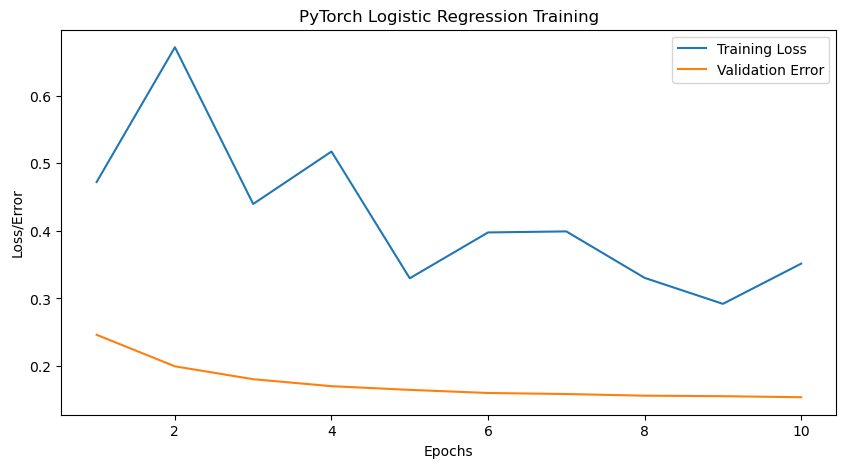

Final Validation Error (PyTorch): 0.15386033058166504


In [121]:
# Part 6: Logistic Regression in PyTorch
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor((y_train + 1) / 2, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor((y_test + 1) / 2, dtype=torch.float32).view(-1, 1)

# Dataloader for mini-batches
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model, loss, optimizer
model = LogisticRegression(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses_torch = []
val_errors_torch = []

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    train_losses_torch.append(loss.item())
    with torch.no_grad():
        val_preds = model(X_test_torch).round()
        val_error = (val_preds != y_test_torch).float().mean().item()
        val_errors_torch.append(val_error)

# Plot PyTorch results
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses_torch, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_errors_torch, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Loss/Error')
plt.legend()
plt.title('PyTorch Logistic Regression Training')
plt.show()

print(f"Final Validation Error (PyTorch): {val_errors_torch[-1]}")

## Part 7: Other Optimization Algorithms in PyTorch.

Training with SGD...
Training with SGD_Momentum...
Training with Adam...


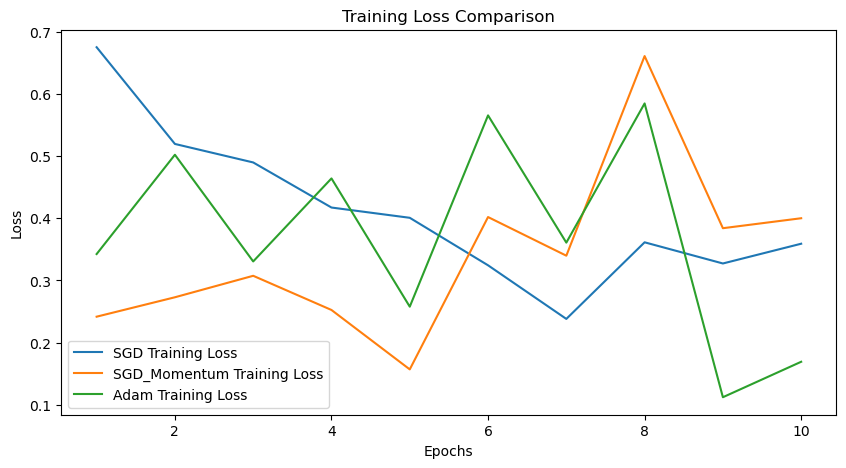

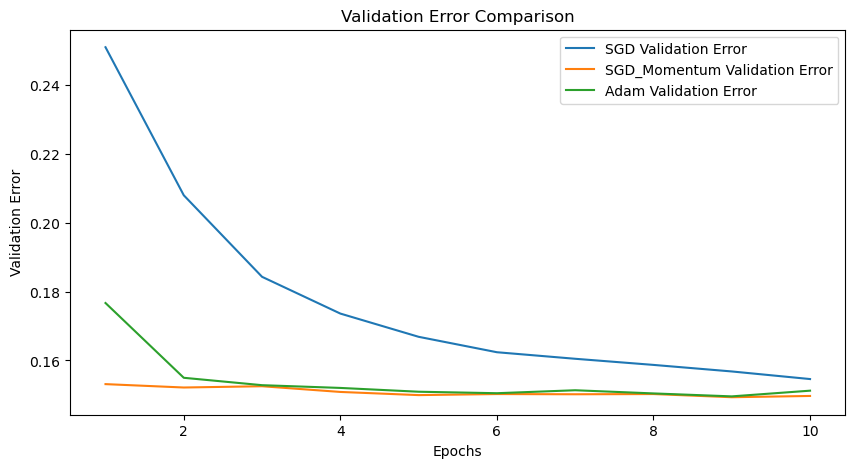

Final Validation Error (SGD): 0.15459738671779633
Final Validation Error (SGD_Momentum): 0.14968368411064148
Final Validation Error (Adam): 0.1512192189693451


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Part 1: Compute Gradient and SGD Update
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logreg_loss(X, y, w):
    """Compute logistic regression loss."""
    m = X.shape[0]
    z = X @ w
    return np.mean(np.log(1 + np.exp(-y * z)))

def logreg_error(X, y, w):
    """Compute classification error."""
    predictions = np.sign(X @ w)
    return np.mean(predictions != y)

def logreg_sgd(X, y, w_init, alpha, sigma, T):
    """Perform SGD for logistic regression."""
    m, n = X.shape
    w = w_init.copy()
    losses = []
    errors = []
    val_errors = []
    
    # Append initial loss/error before training starts
    losses.append(logreg_loss(X, y, w))
    errors.append(logreg_error(X, y, w))
    val_errors.append(logreg_error(X_test, y_test, w))
    
    for t in range(T):
        i = np.random.randint(m)  # Random sample index
        x_i, y_i = X[i], y[i]
        gradient = -y_i * x_i / (1 + np.exp(y_i * (x_i @ w))) + 2 * sigma * w
        w -= alpha * gradient
        
        if (t + 1) % 32561 == 0:
            losses.append(logreg_loss(X, y, w))
            errors.append(logreg_error(X, y, w))
            val_errors.append(logreg_error(X_test, y_test, w))
    
    return w, losses, errors, val_errors

# Part 2: Load Data
def load_data(file_path):
    """Load sparse LibSVM dataset into a dense NumPy array."""
    data = []
    labels = []
    num_features = 123
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            labels.append(int(parts[0]))
            features = np.zeros(num_features + 1)
            features[-1] = 1  # Bias term
            for item in parts[1:]:
                index, value = map(float, item.split(':'))
                features[int(index) - 1] = value
            data.append(features)
    return np.array(data), np.array(labels)

# Load training and test data
X_train, y_train = load_data("a9a.train.txt")
X_test, y_test = load_data("a9a.test.txt")

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor((y_train + 1) / 2, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor((y_test + 1) / 2, dtype=torch.float32).view(-1, 1)

# Dataloader for mini-batches
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Logistic Regression Maodel
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Training function
def train_model(optimizer_name, lr=0.001, momentum=0.9, num_epochs=10):
    model = LogisticRegression(X_train.shape[1])
    criterion = nn.BCELoss()
    
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "SGD_Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("Unsupported optimizer")
    
    train_losses = []
    val_errors = []
    
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        train_losses.append(loss.item())
        with torch.no_grad():
            val_preds = model(X_test_torch).round()
            val_error = (val_preds != y_test_torch).float().mean().item()
            val_errors.append(val_error)
    
    return train_losses, val_errors

# Train and compare different optimizers
optimizers = ["SGD", "SGD_Momentum", "Adam"]
results = {}

for opt in optimizers:
    print(f"Training with {opt}...")
    results[opt] = train_model(opt)

# Plot results
plt.figure(figsize=(10, 5))
for opt in optimizers:
    plt.plot(range(1, 11), results[opt][0], label=f"{opt} Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison')
plt.show()

plt.figure(figsize=(10, 5))
for opt in optimizers:
    plt.plot(range(1, 11), results[opt][1], label=f"{opt} Validation Error")
plt.xlabel('Epochs')
plt.ylabel('Validation Error')
plt.legend()
plt.title('Validation Error Comparison')
plt.show()

for opt in optimizers:
    print(f"Final Validation Error ({opt}): {results[opt][1][-1]}")
